In [ ]:
# Use the environment variable if the user doesn't provide Project ID.
import os

import vertexai
from vertexai.preview.generative_models import (
    FunctionDeclaration,
    GenerativeModel,
    Tool,
    ToolConfig,
    Part,
    GenerationConfig,
)
PROJECT_ID = "104916006626"  # @param {type: "string", placeholder: "[your-project-id]" isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "xyz":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "australia-southeast1")

vertexai.init(project="104916006626", location=LOCATION)

In [ ]:
import os
from google.oauth2 import service_account

# Path to your service account key file
key_path = "C:\\Users\\shres\\Projects\\RAG-case-study\keys\\keyproject-401005-6e1cdcbb5996.json"

# Create credentials using the service account key file
credentials = service_account.Credentials.from_service_account_file(
    key_path
)

# Set the credentials for the current environment
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path
# auth_request = transport.requests.Request()
# credentials.refresh(auth_request)

In [ ]:
# Controlled generation example test
response_schema = {
    "type": "array",
    "items": {
        "type": "object",
        "properties": {
            "recipe_name": {
                "type": "string",
            },
        },
        "required": ["recipe_name"],
    },
}

model = GenerativeModel("gemini-1.5-pro-002")

response = model.generate_content(
    "List a few popular cookie recipes",
    generation_config=GenerationConfig(
        response_mime_type="application/json", response_schema=response_schema
    ),
)

print(response.text)

## Document preprocessing:

Each document is to pre-processed individually as the structure of each document is different from the other. The objective it to extract meaningful chunks out of each document while preserving the original structure of the document, long term and short term context so that the chunk is indexed better and retrieved accurately.
The chunking strategy is as follows:
- LLM to create an index for the document dividing the document into various sections based on heading and sub headings. This will be used as metadata for the chunk.
- The document generates chunks by outputing the first and last sentence for the chunk. The chunk is then extracted from the md file which contains the document text. Generated chunk is restricted insize to a set number of tokens
- Each chunk is appended with short term and long term context for the document to aid the embedding and retrieval process.
- LLM must help remove unnecessary headers and footers  of the document


In [9]:
import logging
import time
from pathlib import Path
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem
from docling.datamodel.base_models import FigureElement, InputFormat, Table
from docling.datamodel.pipeline_options import (
    AcceleratorDevice,
    AcceleratorOptions,
    PdfPipelineOptions,
    TesseractCliOcrOptions,
    TesseractOcrOptions,
)
from docling.document_converter import DocumentConverter, PdfFormatOption

_log = logging.getLogger(__name__)

In [4]:
IMAGE_RESOLUTION_SCALE = 2.0

In [1]:
from pathlib import Path
import logging
from typing import Dict, List
from transformers import AutoTokenizer
from docling.chunking import HybridChunker
from docling.document_converter import DocumentConverter

class DocumentChunker:
    def __init__(self, base_dir: str = "processed_docs", model_id: str = "answerdotai/ModernBERT-base"):
        """
        Initialize the DocumentChunker with necessary components.
        
        Args:
            base_dir: Base directory containing markdown files
            model_id: Model ID for the tokenizer
        """
        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
        self.base_dir = Path(base_dir)
        self.model_id = model_id
        
        # Initialize components
        self._setup_components()
        
        # Store results
        self.document_chunks: Dict[str, List[str]] = {}

    def _setup_components(self) -> None:
        """Initialize tokenizer, chunker and document converter."""
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_id)
        self.chunker = HybridChunker(
            tokenizer=self.tokenizer,
            merge_peers=True,
        )
        self.doc_converter = DocumentConverter()
        
    def process_single_document(self, file_path: Path) -> List[str]:
        """
        Process a single markdown file and return its chunks.
        
        Args:
            file_path: Path to the markdown file
            
        Returns:
            List of chunks for the document
        """
        chunks = []
        
        try:
            # Convert markdown to docling document
            doc = self.doc_converter.convert(source=str(file_path)).document
            
            # Generate and store chunks in order
            for chunk in self.chunker.chunk(dl_doc=doc):
                chunks.append(self.chunker.serialize(chunk=chunk))
                
            self.logger.info(f"Successfully processed {file_path.name} - Generated {len(chunks)} chunks")
            
        except Exception as e:
            self.logger.error(f"Error processing {file_path.name}: {str(e)}")
        
        return chunks

    def process_directory(self) -> Dict[str, List[str]]:
        """
        Process all markdown files in the directory and its subdirectories.
        
        Returns:
            Dictionary mapping document names to their ordered chunks
        """
        # Find all markdown files
        md_files = list(self.base_dir.glob("**/*-with-image-refs.md"))
        
        if not md_files:
            self.logger.warning(f"No markdown files found in {self.base_dir}")
            return self.document_chunks
        
        self.logger.info(f"Found {len(md_files)} markdown files to process")
        
        # Process each file
        for md_file in md_files:
            self.logger.info(f"Processing {md_file.relative_to(self.base_dir)}")
            
            # Store chunks with document name as key
            doc_key = md_file.stem
            self.document_chunks[doc_key] = self.process_single_document(md_file)
        
        self.logger.info(f"Completed processing all documents")
        return self.document_chunks
    
    def get_document_statistics(self) -> None:
        """Print statistics about processed documents and their chunks."""
        if not self.document_chunks:
            print("No documents have been processed yet.")
            return
            
        print("\nDocument Processing Statistics:")
        print("-" * 30)
        for doc_name, chunks in self.document_chunks.items():
            print(f"\nDocument: {doc_name}")
            print(f"Number of chunks: {len(chunks)}")
            if chunks:
                avg_chunk_length = sum(len(self.tokenizer.tokenize(chunk)) 
                                     for chunk in chunks) / len(chunks)
                print(f"Average chunk length: {avg_chunk_length:.2f} tokens")



c:\Users\shres\anaconda3\envs\rag_case_study\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Example usage
if __name__ == "__main__":
    # Initialize the chunker
    doc_chunker = DocumentChunker()
    
    # Process all documents
    document_chunks = doc_chunker.process_directory()
    
    # Print statistics
    doc_chunker.get_document_statistics()
    
    # Access chunks for a specific document
    # doc_name = next(iter(document_chunks))
    # print(f"\nFirst chunk of {doc_name}:")
    # print(document_chunks[doc_name][0][:500])

INFO:__main__:Found 3 markdown files to process
INFO:__main__:Processing AI_ACT\AI_ACT-with-image-refs.md
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.pipeline.base_pipeline:Processing document AI_ACT-with-image-refs.md
INFO:docling.document_converter:Finished converting document AI_ACT-with-image-refs.md in 267.88 sec.
Token indices sequence length is longer than the specified maximum sequence length for this model (8230 > 8192). Running this sequence through the model will result in indexing errors
INFO:__main__:Successfully processed AI_ACT-with-image-refs.md - Generated 152 chunks
INFO:__main__:Processing Cybersecurity_California_Privacy\Cybersecurity_California_Privacy-with-image-refs.md
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.pipeline.base_pipeline:Processing document Cybersecurity_California_Privacy-with-image-refs.md
INFO:docling.document_converter:Finished converting document Cybersecurity_California_Pr


Document Processing Statistics:
------------------------------

Document: AI_ACT-with-image-refs
Number of chunks: 152
Average chunk length: 1133.82 tokens

Document: Cybersecurity_California_Privacy-with-image-refs
Number of chunks: 41
Average chunk length: 266.54 tokens

Document: GDPR-with-image-refs
Number of chunks: 122
Average chunk length: 938.01 tokens


Total chunks: 122
Mean length: 930.85 tokens
Median length: 457.50 tokens
Min length: 2 tokens
Max length: 8163 tokens
Standard deviation: 1666.86 tokens


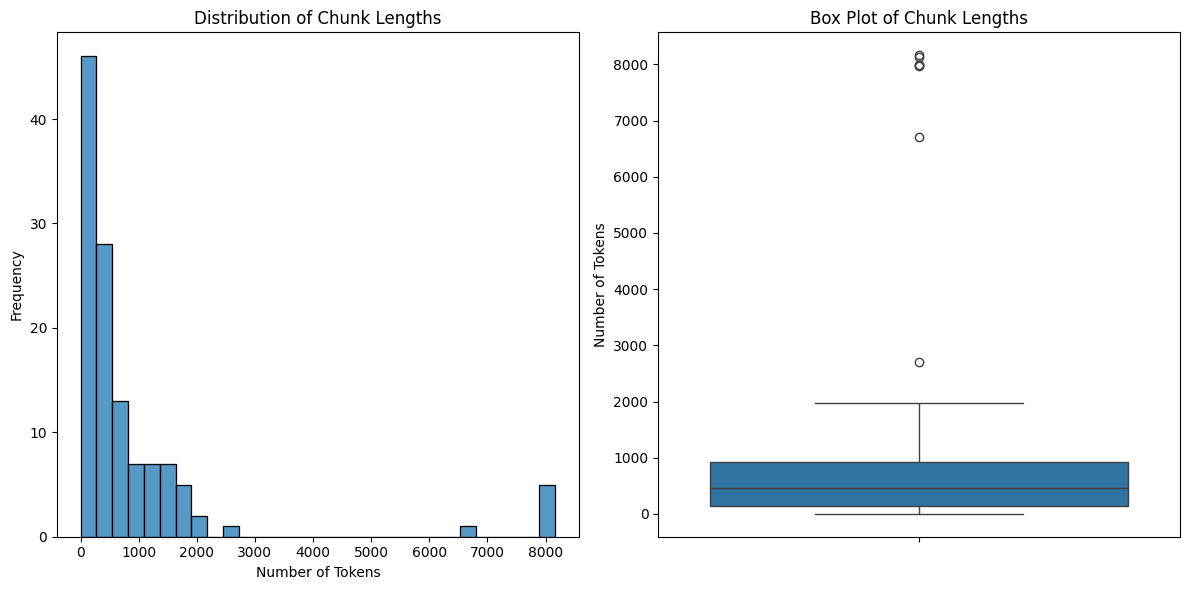

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_chunk_distribution(doc, tokenizer, chunker):
    """Analyze the distribution of chunk lengths."""
    chunk_lengths = []
    
    # Get chunks and their lengths
    for chunk in chunker.chunk(dl_doc=doc):
        txt_tokens = len(tokenizer.tokenize(chunk.text, max_length=None))
        chunk_lengths.append(txt_tokens)
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(chunk_lengths, bins=30)
    plt.title('Distribution of Chunk Lengths')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=chunk_lengths)
    plt.title('Box Plot of Chunk Lengths')
    plt.ylabel('Number of Tokens')
    
    plt.tight_layout()
    
    # Print statistics
    print(f"Total chunks: {len(chunk_lengths)}")
    print(f"Mean length: {np.mean(chunk_lengths):.2f} tokens")
    print(f"Median length: {np.median(chunk_lengths):.2f} tokens")
    print(f"Min length: {np.min(chunk_lengths)} tokens")
    print(f"Max length: {np.max(chunk_lengths)} tokens")
    print(f"Standard deviation: {np.std(chunk_lengths):.2f} tokens")
    
    return chunk_lengths

# Run the analysis
chunk_lengths = analyze_chunk_distribution(doc, tokenizer, chunker)